# Implementing First Order Advection

We now have all the pieces needed to implement first-order accurate advection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

For convenience, the grid module we already saw can by imported

In [2]:
import fv_grid

Now we'll write our driver.  We'll take as input:

* `nx` : the number of zones
* `u` : the advective velocity
* `C` : the CFL number

we can also specify the number of periods and pass in the function that supplies the initial conditions

In [3]:
def advection(nx, u, C, num_periods=1, init_cond=None):
    
    # create the grid
    g = fv_grid.FVGrid(nx, ng=1)
    
    # compute the stop time
    t_period = (g.xmax - g.xmin) / np.abs(u)
    tmax = num_periods * t_period
    
    # setup the initial conditions and store them for later
    # plotting
    init_cond(g)
    g.ainit[:] = g.a[:]
    
    # compute the timestep
    dt = C * g.dx / np.abs(u)
    
    # evolution loop
    t = 0.0
    while t < tmax:
        if t + dt > tmax:
            dt = tmax - t

        g.fill_BCs(g.a)
        
        # get the interface states -- just piecewise constant -- we need
        # an interface state on each boundary, so for nx zones there are
        # nx + 1 interface states
        
        aleft = g.scratch_array()
        aleft[g.ilo:g.ihi+2] = g.a[g.ilo-1:g.ihi+1]
        
        aright = g.scratch_array()
        aright[g.ilo:g.ihi+2] = g.a[g.ilo:g.ihi+2]
        
        # solve the Riemann problem -- just upwinding
        aint = np.where(u > 0, aleft, aright)

        # compute the fluxes
        flux = u * aint

        # conservative update
        g.a[g.ilo:g.ihi+1] += -dt/g.dx * (flux[g.ilo+1:g.ihi+2] - flux[g.ilo:g.ihi+1])

        t += dt
        
    return g

## Initial conditions

We need to supply a function that provides the initial conditions.  It has the signature:
```
init_cond(FVGrid)
```

First up: the tophat

In [4]:
def tophat(g):
    g.a[:] = 0.0
    g.a[np.logical_and(g.x >= 1./3, g.x <= 2./3.)] = 1.0

Now we'll run it.

In [20]:
nx = 128
u = 1
C = 0.8

In [21]:
g = advection(nx, u, C, init_cond=tophat)

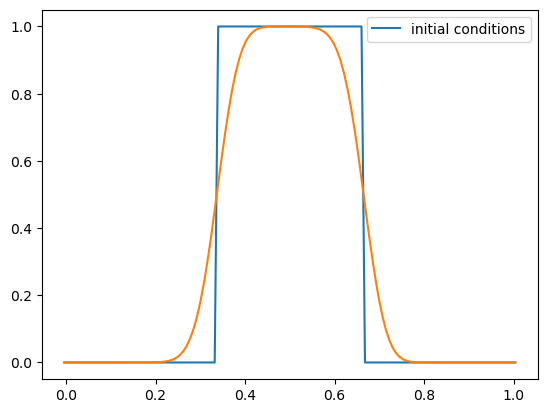

In [22]:
fig = g.plot()

This is very diffusive, but that's to be expected for a first-order accurate method.

Now let's try the Gaussian initial conditions

In [23]:
def gaussian(g):
    g.a[:] = np.exp(-40.0*(g.x - 0.5)**2)

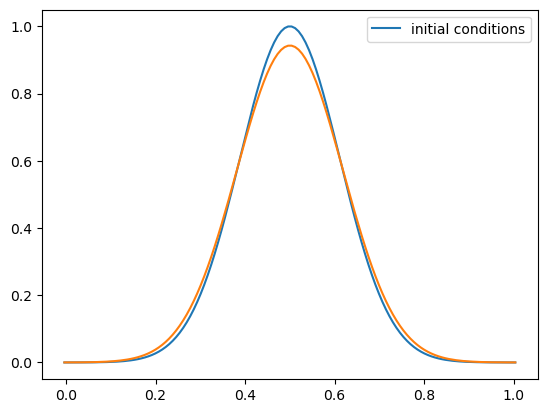

In [24]:
g = advection(nx, u, C, init_cond=gaussian)
fig = g.plot()

This looks a little better&mdash;we can still see the basic shape.